# Celebrity Facial Recognition with Facenet in PyTorch

## Introduction

<hr>

### Motivation




## Initial Preparations

For this implementation, we will be using `PyTorch` mainly and `torchvision` to process our image(JPEG) data.

Data is taken from [kaggle user, burak](https://www.kaggle.com/datasets/hereisburak/pins-face-recognition), already downloaded and unzipped

In [52]:
%matplotlib inline
import torch
import os
import glob
import numpy as np
import random
from math import floor

In [2]:
DATA_DIR = 'data'
IMG_DIR = os.path.join(DATA_DIR, '105_classes_pins_dataset')
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(42) # set random seed

### 1. Exploring the Data

In this dataset, the images are grouped by person and inside their respective directories. As such, we'll extract the class names from the directory name. However, the individual subdirectories are prefixed with `pins_` before the class name, ie. the celebrity name. We can process that later once we know what data we're dealing with.

First we need to find out the dimensions of each image by getting some random samples

In [3]:
# Get list of folder names
celeb_names = next(os.walk(IMG_DIR))[1]

In [4]:

from PIL import Image
def get_random_image(dir: str) -> tuple[torch.Tensor,str]:
    # get random image from a directory where images are group by subdirectory
    # return image tensor and label
    # params: dir - images directory path
    dir_names = next(os.walk(dir))[1]
    rand_dir = random.choice(dir_names) # random.choice() seems to be a bit more intuitive than random.sample()
    rand_img_path = random.choice(glob.glob(os.path.join(IMG_DIR,rand_dir,'*.jpg')))
    # rand_img = read_image(rand_img_dir) # torchvision.io.read_image() # read_image() imports a Tensor
    rand_img = Image.open(rand_img_path) # using PIL so we can pipe this into a torchvision transform
    return (rand_img,rand_dir)

In [5]:
# get 3 samples to compare
img_sample_1, img_label_1 = get_random_image(IMG_DIR)
img_sample_2, img_label_2 = get_random_image(IMG_DIR)
img_sample_3, img_label_3 = get_random_image(IMG_DIR)

# print out information
print('Label\t\t\t|\tShape')
print('--------------------------------------')
print(f'{img_label_1}\t| {img_sample_1.size}')
print(f'{img_label_2}\t| {img_sample_2.size}')
print(f'{img_label_3}\t| {img_sample_3.size}')

Label			|	Shape
--------------------------------------
pins_Chris Evans	| (145, 129)
pins_Brie Larson	| (146, 155)
pins_Keanu Reeves	| (302, 320)


In [7]:
import matplotlib.pyplot as plt
import PIL.Image

def plot_images(*args: PIL.Image.Image) -> None:
    # params: *args - array of PIL Images
    fig, ax = plt.subplots(1,len(args))
    for img,i in zip(args,range(len(args))):
        ax[i].imshow(img)

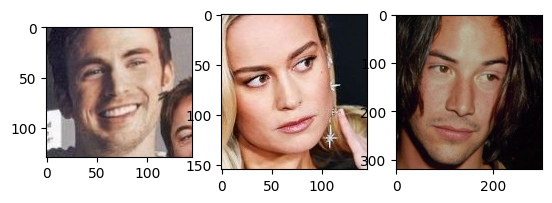

In [8]:
plot_images(img_sample_1,img_sample_2,img_sample_3)

We can see that the dimensions are not the same. We'll need to make all these uniform so we'll choose a shape of `(220,220)` to resize our data. This is the input dimension which the was used to train the FaceNet model *(Schroff, et al)*, which will be coding from scratch in the next section.

In [9]:
from torchvision import transforms

img_transforms = transforms.Compose(
                    transforms=[transforms.Resize(size=(220,220)),
                    transforms.ToTensor()]
                    )

In [10]:
# test out the transform on one of the image samples
img_transformed_1 = img_transforms(img_sample_1)
print(f'new shape: {img_transformed_1.shape}')

new shape: torch.Size([3, 220, 220])


(-0.5, 219.5, 219.5, -0.5)

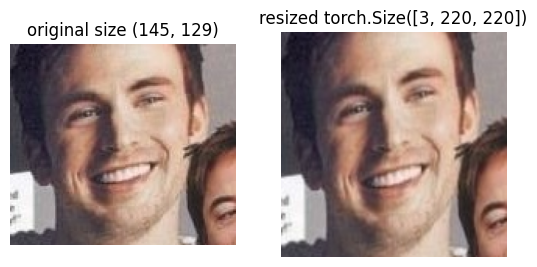

In [11]:
# compare before and after
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_sample_1)
ax[0].set_title(f'original size {img_sample_1.size}')
ax[0].axis('off')
ax[1].imshow(img_transformed_1.permute(1,2,0))
ax[1].set_title(f'resized {img_transformed_1.shape}')
ax[1].axis('off')

### 2. Preparing the Data

Now that we figured out what our raw inputs are like and what they should be processed into, we can proceed with loading them into usuable data. As mentioned before we want to do a stratified split but can be tricky with raw (semi) unstructured data like images so I figured out the following workflow:

- generate metadata with input column as the path to the image file and the class column as the subfolder. This will be done in `pandas` because tensors can't hold string data. (i could also use numpy since it might generate less overhead, but I'm using what I'm accustomed to. I might convert this into numpy in the future)
    | Path  | Class |
    |-------|-------|
    | root/class1_folder/image1.jpg | class1_folder |
    | root/class1_folder/image2.jpg | class1_folder |
    | root/class2_folder/image1.jpg | class2_folder |
- since the class folders have a prefix, in a pandas dataframe one can easily manipulate strings to remove all entries in the `Class` column
- feed dataframe into a `scikit-learn` stratified split to split into train and test data(and possibly a validation). This guarantees an even split for each class. Note: at the time of writing `Pytorch` does not have any function for doing stratified sampling so we need to come up with other ways. One can code a sampling function from scratch but `scikit-learn`'s library is a good and easy way to achieve that
- feed separate train and test datasets into a custom `Dataset` object, which loads images based on the metadata
- feed `Dataset` object into `Dataloaders` to be ready for processing

An alternative could be using `ImageFolder` and loading the featurized image data and assigning them classes 

#### 2.1 Generate Metadata

In [12]:
import pandas as pd

def load_data(path: str) -> pd.DataFrame:
    df = pd.DataFrame()
    for c in glob.glob(os.path.join(path,'*')):
        X = []
        y = []
        for i in glob.glob(os.path.join(c,'*.jpg')):
            X.append(i)
            y.append(os.path.basename(c))
        df = pd.concat([df,pd.DataFrame({'X': X, 'y': y})], axis=0)
        

    return df

In [13]:
df = load_data(IMG_DIR)

In [14]:
# look at dataframe info, making sure there are no nulls
# and making sure there are exactly 17534 images
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17534 entries, 0 to 121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   X       17534 non-null  object
 1   y       17534 non-null  object
dtypes: object(2)
memory usage: 411.0+ KB


In [15]:
# a quick look at the counts for each class
# as well as making sure there are 105 classes
df.y.value_counts()

y
pins_Leonardo DiCaprio     237
pins_Robert Downey Jr      233
pins_Katherine Langford    226
pins_Alexandra Daddario    225
pins_margot robbie         221
                          ... 
pins_Morgan Freeman        105
pins_Brian J. Smith        102
pins_Cristiano Ronaldo      98
pins_Mark Zuckerberg        95
pins_Lionel Messi           86
Name: count, Length: 105, dtype: int64

In [16]:
# now just some final cleaning tasks, we'll strip the prefix `pins_` for every class name to make it look decent
df['y'] = df.y.str.replace('^pins_','',regex=True)

In [17]:
# verify change
df.y.value_counts()

y
Leonardo DiCaprio     237
Robert Downey Jr      233
Katherine Langford    226
Alexandra Daddario    225
margot robbie         221
                     ... 
Morgan Freeman        105
Brian J. Smith        102
Cristiano Ronaldo      98
Mark Zuckerberg        95
Lionel Messi           86
Name: count, Length: 105, dtype: int64

#### 2.1.1 Tangenting: Plot Distributions

Now that we've generated metadata, it'll be a lot easier to visualize distributions for each class. 

In [18]:
dist_classes = df.groupby('y').count()

In [19]:
dist_x = dist_classes.index.values

In [20]:
dist_classes.X.values

array([213, 152, 225, 139, 117, 196, 203, 124, 162, 126, 122, 138, 209,
       102, 169, 166, 159, 176, 154,  98, 181, 146, 141, 162, 158, 210,
       139, 211, 187, 195, 179, 127, 156, 159, 184, 180, 167, 141, 113,
       182, 117, 177, 226, 160, 171, 237, 150, 169,  86, 212, 192, 193,
       122, 161, 178,  95, 209, 178, 191, 175, 105, 133, 198, 166, 116,
       125, 171, 160, 178, 148, 133, 156, 233, 159, 186, 154, 204, 159,
       131, 192, 198, 181, 189, 133, 167, 179, 191, 138, 186, 211, 218,
       119, 197, 162, 221, 188, 135, 199, 183, 106, 203, 221, 154, 201,
       180])

/tmp/ipykernel_30807/2554215320.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(dist_x, rotation=-80)


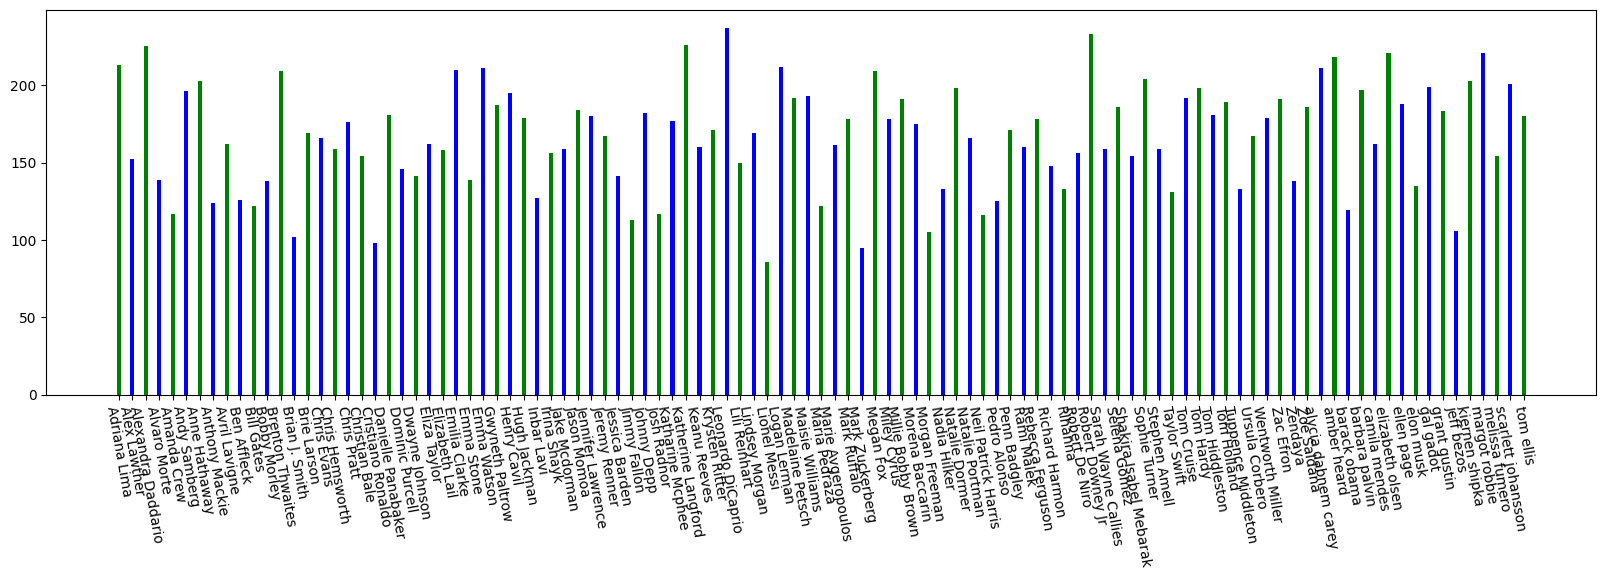

In [21]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot()
ax.bar(x=dist_x, height=dist_classes.X.values, color={'green','blue'}, width=0.3)
_ = ax.set_xticklabels(dist_x, rotation=-80)

In [22]:
# and before we proced, it would be a good idea to store all the class names, in order

#### 2.2 Split Metadata Into Train and Test sets
Now that we've created the metadata as a datafram, we can now do a stratified split:

- feed the cleaned dataframe into `StratifiedShuffleSplit` that will split the data evenly into test and train datasets
- now with test and train sets, we can use the metadata and feed it into our custom `Dataset` object that will load the image data and transform it
- create dataloaders to feed data in batches

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

ssplit = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42) # 5 splits, with 70-30 train-test split per class

In [24]:
ssplit.get_n_splits(df.X,df.y)

5

In [25]:
for i,(train_df, test_df) in enumerate(ssplit.split(df.X,df.y)):
    print(f'fold {i}:')
    print(f'Train:\tsize={len(train_df)}\tindex={train_df}')
    print(f'Test:\tsize={len(test_df)}\tindex={test_df}')

fold 0:
Train:	size=12273	index=[10896  8269  2151 ... 10886 10915 12498]
Test:	size=5261	index=[ 9137 15220  1451 ...  2141  4601  5530]
fold 1:
Train:	size=12273	index=[ 2097 11621 10521 ... 14034  9179  8200]
Test:	size=5261	index=[ 6915  7181 11763 ... 15663 12328  4460]
fold 2:
Train:	size=12273	index=[7836 3813 8296 ... 2047 7431 3424]
Test:	size=5261	index=[16090  3111  9170 ... 14257  5693  2504]
fold 3:
Train:	size=12273	index=[ 9314 15679  9301 ... 12870 12169  6116]
Test:	size=5261	index=[ 8803  3136  6610 ...  3740 15925 10943]
fold 4:
Train:	size=12273	index=[ 6878  3785 14138 ... 16553  4662  4798]
Test:	size=5261	index=[ 7715  9108  7382 ... 12060 12131 15095]


In [26]:
df.iloc[train_df[0]].X

'data/105_classes_pins_dataset/pins_Lili Reinhart/Lili Reinhart129_2732.jpg'

#### 2.3 Create Custom Dataset and Dataloaders

Now we have stratified train and test sets, let's define our custom `Dataset` class that requires the metadata that we generated(the image paths and the corresponding )

One challenge for this is converting class names(categorical) into something our model can process. A possible solution would be to assign an integer for each corresponding name. `scikit-learn`'s `sklearn.preprocessing.LabelEncoder()` can help us with that.

There are other methods such as `one-hot encoding` but in this case, we want to code something simple, even for us.

In [27]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.preprocessing import LabelEncoder

class FaceDataset(Dataset):
    le = LabelEncoder()
    def __init__(self, df: pd.DataFrame, ind: np.ndarray, transform=None) -> None:
        """
        params: 
            df - metadata dataframe; X as image paths and y as image label
            ind - stratified indices generated from StratifiedShuffleSplit
            transform - torchvision transforms
        """
        # go into image directory
        # load image and featurize
        self.X_paths = [ df.iloc[i].X for i in ind ]
        self.y_categorical = [ df.iloc[i].y for i in ind ]
        self.y = self.le.fit_transform(self.y_categorical) # convert categorical data into numerical
        self.y_class_names = list(self.le.classes_) # get class names
        self.transform=transform
    def __load_img(self,path: str) -> PIL.Image.Image:
        return Image.open(path)
    def get_class_name(self,y):
        return self.le.inverse_transform([y])
    def __len__(self) -> int:
        return len(self.X_paths)
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        img = self.__load_img(self.X_paths[idx])
        label = self.y[idx]
        if self.transform is not None:
            return self.transform(img), label
        else:
            return img, label

In [28]:
# let's try this out. We'll be using the same transforms object from earlier
train_dataset = FaceDataset(df,train_df,transform=img_transforms)
test_dataset = FaceDataset(df,test_df,transform=img_transforms)

In [29]:
len(train_dataset), len(test_dataset)

(12273, 5261)

In [30]:
train_dataset.y_class_names

['Adriana Lima',
 'Alex Lawther',
 'Alexandra Daddario',
 'Alvaro Morte',
 'Amanda Crew',
 'Andy Samberg',
 'Anne Hathaway',
 'Anthony Mackie',
 'Avril Lavigne',
 'Ben Affleck',
 'Bill Gates',
 'Bobby Morley',
 'Brenton Thwaites',
 'Brian J. Smith',
 'Brie Larson',
 'Chris Evans',
 'Chris Hemsworth',
 'Chris Pratt',
 'Christian Bale',
 'Cristiano Ronaldo',
 'Danielle Panabaker',
 'Dominic Purcell',
 'Dwayne Johnson',
 'Eliza Taylor',
 'Elizabeth Lail',
 'Emilia Clarke',
 'Emma Stone',
 'Emma Watson',
 'Gwyneth Paltrow',
 'Henry Cavil',
 'Hugh Jackman',
 'Inbar Lavi',
 'Irina Shayk',
 'Jake Mcdorman',
 'Jason Momoa',
 'Jennifer Lawrence',
 'Jeremy Renner',
 'Jessica Barden',
 'Jimmy Fallon',
 'Johnny Depp',
 'Josh Radnor',
 'Katharine Mcphee',
 'Katherine Langford',
 'Keanu Reeves',
 'Krysten Ritter',
 'Leonardo DiCaprio',
 'Lili Reinhart',
 'Lindsey Morgan',
 'Lionel Messi',
 'Logan Lerman',
 'Madelaine Petsch',
 'Maisie Williams',
 'Maria Pedraza',
 'Marie Avgeropoulos',
 'Mark Ruffal

In [31]:
# let's try picking a sample at random
random_sample  = train_dataset[69]

In [32]:
# check image dimensions
random_sample_image = random_sample[0]
random_sample_image.shape

torch.Size([3, 220, 220])

In [33]:
random_sample_label = random_sample[1]
print(f'{random_sample_label} = {train_dataset.get_class_name(random_sample_label)}')

15 = ['Chris Evans']


Now, a note on this regarding the `LabelEncoder`: since there are two separate datasets created independent of each other(train and test), that means the label encoder inside the class works independently. From seeing how it works, it orders the classes alphabetically, then assigns an integer value from *0* to *n-1*, where n is the number of classes. So, assuming all classes are present in the train dataset, and by applying stratified sampling each class should have equal representation according to the train-test ratio defined, the label encoder in the `test` dataset should have an equal number of classes and have the same encoded labels as `train`.

We can double check by calling the `get_class_name()` method on the `test_dataset` object and input the same label(`int`) from the sample we picked out.

In [34]:
# double check if encoded labels in test match the ones in train
test_dataset.get_class_name(15)

array(['Chris Evans'], dtype='<U22')

Ok, now it looks like they match up. Let's see if the label matches the image in the data by plotting it

Text(0.5, 1.0, "['Chris Evans'] torch.Size([3, 220, 220])")

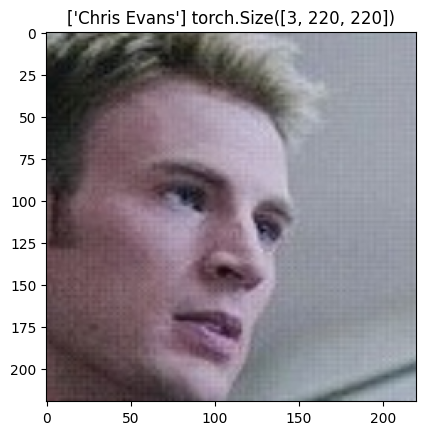

In [35]:
# let's plot to make sure the label matches the image
plt.imshow(random_sample[0].permute(1,2,0))
plt.title(f'{train_dataset.get_class_name(random_sample_label)} {random_sample[0].shape}')

So far, at the time of writing this, the plot correctly showed the class that it belongs to. But I'm not convinced yet so let's pick 4 random samples and plot them

In [36]:
def plot_random_images(dataset: Dataset, n: int=4) -> None:
    '''
    picks 4 datapoints at random and plots them
    params: 
        dataset - torch custom Dataset object
        n - number of samples to pick
    '''
    random_samples = random.sample(range(len(dataset)), k=n)
    fig, ax = plt.subplots(1,len(random_samples),figsize=(len(random_samples)*2,5))
    for img,i in zip([dataset[i] for i in random_samples], range(len(random_samples))):
        ax[i].imshow(img[0].permute(1,2,0))
        ax[i].set_title(dataset.get_class_name(img[1]), fontsize=9) # get label and translate into classnames

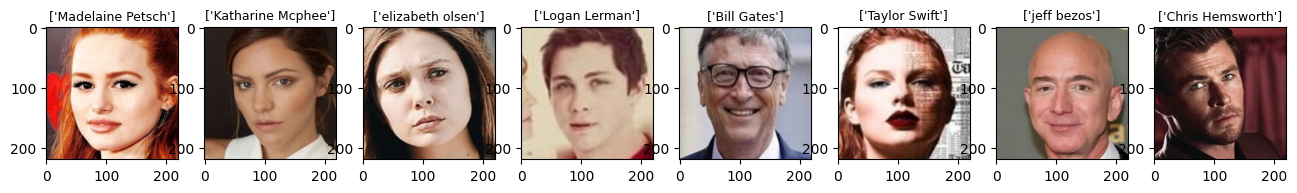

In [37]:
plot_random_images(train_dataset,n=8)

So far so good. Now let's do the `test_dataset`

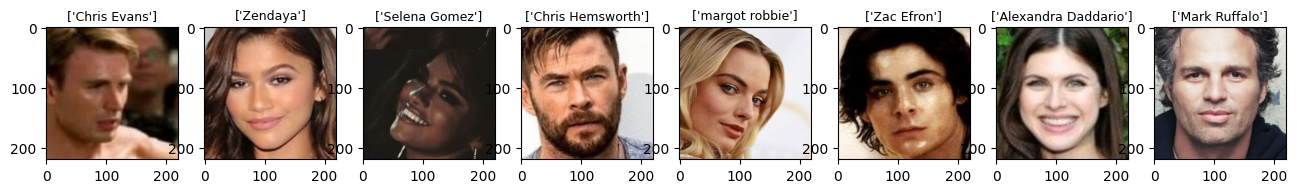

In [38]:
plot_random_images(test_dataset, 8)

It's looking great. Our data is ready for processing. Next step is creating the model

### 3. Model: FaceNet 

This notebook is a demonstration of the FaceNet architecture. We'll be following along with the paper *(Schroff, et al.2015)* 

<div style="text-align: center;">

![Fig. 1](static/FaceNet_arch.png)

*Fig. 1 High-level overview of the FaceNet Architecture*

</div>

FaceNet utilizes a separate core architecture. In the paper, one of the architectures used was an *Inception* type network, specifically the *GoogLeNet* architecture *(Szegedy, et al. 2016)*, which we will code from scratch. However, we'll be using a modified version of the Inception(Inception V1) network that was used for the FaceNet paper.

<div style="text-align: center;">

![Fig. 2](static/InceptionV1_modified.png)

*Fig. 2 Architectural details for the modified Inception-V1 model*

</div>

For reference, below are the details of Inception V1(GoogLeNet)

<div style="text-align: center;">

![Fig. 3](static/GoogLeNet_arch.png)

*Fig. 3 Inception V1/GoogLeNet architectural details*

</div>

#### 3.1 Inception V1 Architecture and Inception Modules

As the FaceNet architecture relies on another deep architecture such as Inception, we need to have a basic understanding of the Inception architecture. Inception V1(GoogLeNet) has 22 layers deep and is made of multiple Inception layers. Where each inception module has different convolutional blocks that have 1x1, 3x3, 5x5, and a 3x3 max pool block.

<div style="text-align: center;">

![Fig. 4](static/InceptionModuleNaive.png)

*Fig. 4 naive Inception block*

</div>

As programmers I think we can understand it better when we code it

The Inception module diagram shows having 4 branches consisting of 1x1, 3x3, 5x5, and a 3x3 max pool branch and then the outputs are concatenated. we separate outputs for all branches

In [40]:
from torch import nn

class InceptionModuleNaive(nn.Module):
    def __init__(self, 
                 in_channels: int,
                 out_1x1: int, # output of 1x1 conv
                 out_3x3: int, # output of 3x3 conv
                 out_5x5: int # output of 5x5 conv
                 ) -> None:
        super().__init__()
        # branch 1 - 1x1 filter/kernel size
        self.branch1 = nn.Sequential(
            ConvBlock(in_channels, out_1x1, kernel_size=(1,1))
        )

        # branch 2 - 3x3 filter/kernel size
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, out_3x3, kernel_size=(3,3)),
        )

        # branch 3 - 5x5 filter/kernel size
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, out_5x5, kernel_size=(5,5))
        )

        # branch 4 - 3x3 max pooling block
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3,3), stride=(1,1), padding=(1,1))
        )
    
    def forward(self, x):
        x = torch.cat([
            self.branch1(x),
            self.branch2(x),
            self.branch3(x),
            self.max_pool(x)
        ], 1)
        return x

However the problem with the naive module is that 5x5 convolutions can be computationally expensive. To solve this, dimensionality reduction was introduced to lessen the computational load -  a 1x1 convolutional block is added before the 3x3 and 5x5 blocks 

<div style="text-align: center;">

![Fig. 5](static/InceptionModuleDimReg.png)

*Fig. 5 Inception module with dimensionality reduction*

</div>

In [41]:

# most modern architectures use convolutional blocks multiple times so it's best to define a class that can be reused especially when coding multi-layer architectures
class ConvBlock(nn.Module):
    def __init__(self, 
                 in_channels: int,
                 out_channels: int,
                 **kwargs) -> None:
        super().__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs) # kernel_size, stride, and padding parameters can be passed via the kwargs parameter
        self.batch_norm = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x

# As it I believe it will make it easier for us to build the module and customize, We'll build it on top of branches
class Branch(nn.Module):
    def __init__(self, 
                 in_channels: int,
                 red_out: int, # dim reduction output, going into conv layer
                 out_channels: int,
                 k: int, # kernel size
                 reduce: bool=True,
                  *args,
                  **kwargs):
        super().__init__()

        # padding needs to be half the size(approximately) of the kernel
        p = floor(k/2)
        if reduce:
            self.branch = nn.Sequential(
                ConvBlock(in_channels=in_channels,
                        out_channels=red_out, kernel_size=(1,1)),
                ConvBlock(in_channels=red_out,
                          out_channels=out_channels, kernel_size=(k,k), stride=(1,1),padding=(p,p))        
        )
        else:
            self.branch = ConvBlock(in_channels=in_channels,
                                    out_channels=out_channels, kernel_size=(k,k))
            
    def forward(self, x):
        return self.branch(x)

In [42]:
# L2 pooling class; Authors of the paper argue that L2 pooling had better results than max pooling. We're going to be following the architectural details anyway so 
# it would be great if we could see L2 pooling in action. 
# I patterned this class from an SO post here:
# https://stackoverflow.com/questions/36620995/how-to-use-l2-pooling-in-tensorflow
# and pytorch forums here:
# https://discuss.pytorch.org/t/how-do-i-create-an-l2-pooling-2d-layer/105562/4

class L2Pool(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.n = kwargs['kernel_size'][0]
        self.pool = nn.AvgPool2d(*args, **kwargs)
    def forward(self, x):
        return torch.sqrt(self.pool(torch.square(x))*self.n)

In [43]:
# building from the building blocks
class InceptionModuleV1(nn.Module):
    def __init__(self, 
                 in_channels: int,
                 out_1x1: int,
                 red_3x3: int,
                 out_3x3: int,
                 red_5x5: int,
                 out_5x5: int,
                 out_pool: int,
                 l2: bool = False): # change back to L2 == True once L2 pooling class has been fixed
        super().__init__()

        self.branch0 = Branch(in_channels=in_channels,red_out=None,out_channels=out_1x1, k=1, reduce=False) # red_out isnt' used in this case but args with default need to be after positional
                                                                                                            # TODO: move red_out argument towards the end with default None

        self.branch1 = Branch(in_channels=in_channels,
                              red_out=red_3x3,
                              out_channels=out_3x3,
                              k=3)
        self.branch2 = Branch(in_channels=in_channels,
                              red_out=red_5x5,
                              out_channels=out_5x5,
                              k=5)
        if l2:
            self.pool = nn.Sequential(
                L2Pool(kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                ConvBlock(in_channels=in_channels,
                          out_channels=out_pool,
                          kernel_size=(1,1),stride=(2,2))
            )
        else:
            self.pool = nn.Sequential(
                nn.MaxPool2d(kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                ConvBlock(in_channels=in_channels,
                          out_channels=out_pool,
                          kernel_size=(1,1))
            )
    def forward(self, x):
        x = torch.cat([ self.branch0(x),
                       self.branch1(x),
                       self.branch2(x),
                       self.pool(x)], 1)
        return x

# used in 3c and 4e blocks
class Inception3c(nn.Module):
    def __init__(self,
                 in_channels: int,
                 red_3x3: int,
                 out_3x3: int,
                 red_5x5: int,
                 out_5x5: int,
                 ):
        super().__init__()
        # paired
        self.branch0 = Branch(in_channels=in_channels,
                              red_out=red_3x3,
                              out_channels=out_3x3,
                              k=3)
        self.branch1 = Branch(in_channels=in_channels,
                              red_out=red_3x3,
                              out_channels=out_3x3,
                              k=3)
        # paired
        self.branch2 = Branch(in_channels=in_channels,
                              red_out=red_5x5,
                              out_channels=out_5x5,
                              k=5)
        self.branch3 = Branch(in_channels=in_channels,
                              red_out=red_5x5,
                              out_channels=out_5x5,
                              k=5)
        
    def forward(self, x):
        x = torch.cat([self.branch0(x),
                    self.branch1(x),
                    self.branch2(x),
                    self.branch3(x)], 1)
        return x

class Inception4e(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_1x1: int,
                 red_3x3: int,
                 out_3x3: int,
                 red_5x5: int,
                 out_5x5: int,
                 ):
        super().__init__()
        # paired
        self.branch0 = Branch(in_channels=in_channels,
                              red_out=None,
                              out_channels=out_1x1,
                              reduce=False,
                              k=1)
        self.branch1 = Branch(in_channels=in_channels,
                              red_out=red_3x3,
                              out_channels=out_3x3,
                              k=3)
        self.branch2 = Branch(in_channels=in_channels,
                              red_out=red_3x3,
                              out_channels=out_3x3,
                              k=3)
        # paired
        self.branch3 = Branch(in_channels=in_channels,
                              red_out=red_5x5,
                              out_channels=out_5x5,
                              k=5)
        self.branch4 = Branch(in_channels=in_channels,
                              red_out=red_5x5,
                              out_channels=out_5x5,
                              k=5)
        
    def forward(self, x):
        x = torch.cat([self.branch0(x),
                    self.branch1(x),
                    self.branch2(x),
                    self.branch3(x),
                    self.branch4(x)], 1)
        return x

# in the architectural details there's one inception module that only has a 3x3 conv block so we'll make a custom class for the sake of readability
class InceptionModule_0(nn.Module):
    def __init__(self, in_channels: int,
                  reduce_3x3: int,
                  out_3x3: int) -> None:
        super().__init__()
        self.reduce = ConvBlock(in_channels,reduce_3x3,kernel_size=(1,1), stride=(1,1))
        self.conv_block = ConvBlock(reduce_3x3,out_3x3,kernel_size=(3,3),stride=(1,1))
        self.branch = nn.Sequential(
            self.reduce,
            self.conv_block
        )
    def forward (self, x):
        return self.branch(x)

Now that we have the building blocks we'll  get on to coding the main model class using  `FaceNet`'s architectural guidelines

In [44]:
# main class
class FaceNet(nn.Module):
    def __init__(self, 
                 in_channels: int,
                 out_channels: int,
                 *args, **kwargs) -> None:
        super().__init__()

        # block 1
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, # 3 channels for RGB
            out_channels=64,
            kernel_size=(7,7),
            stride=(2,2)
        )

        self.max_pool_1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)) 
        self.batch_norm_1 = nn.BatchNorm2d(64, eps=0.001)

        self.block_1 = nn.Sequential(self.conv1, self.max_pool_1,self.batch_norm_1)

        # block 2
        self.inception_2 = InceptionModule_0(64,64,192)
        
        self.batch_norm_2 = nn.BatchNorm2d(192, eps=0.001)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=(3,3),stride=(2,2))

        self.block_2 = nn.Sequential(self.inception_2,
                                     self.batch_norm_2,
                                     self.max_pool_2)
        

        # block 3
        self.inception_3a = InceptionModuleV1(192,64,96,128,16,32,32,l2=False)
        self.inception_3b = InceptionModuleV1(256,64,96,128,32,64,64)
        self.inception_3c = Inception3c(320,128,256,32,64)
        
        self.max_pool_3 = nn.MaxPool2d(kernel_size=(3,3),stride=(2,2))
        
        self.block_3 = nn.Sequential(self.inception_3a,
                                     self.inception_3b,
                                     self.inception_3c,
                                     self.max_pool_3)

        # block 4
        self.inception_4a = InceptionModuleV1(640,256,96,192,32,64,128)
        self.inception_4b = InceptionModuleV1(640,224,112,224,32,64,128)
        self.inception_4c = InceptionModuleV1(640,192,128,256,32,64,128)
        self.inception_4d = InceptionModuleV1(640,160,144,288,32,64,128)
        self.inception_4e = Inception4e(640,256,160,256,64,128)

        self.max_pool_4 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))

        self.block_4 = nn.Sequential(self.inception_4a,
                                     self.inception_4b,
                                     self.inception_4c,
                                     self.inception_4d,
                                     self.inception_4e,
                                     self.max_pool_4)

        # block 5
        self.inception_5a = InceptionModuleV1(1024,384,192,384,48,128,128)
        self.inception_5b = InceptionModuleV1(1024,384,192,384,48,128,128)

        self.block_5 = nn.Sequential(self.inception_5a,
                                     self.inception_5b)

        self.avg_pool = nn.AvgPool2d(kernel_size=(7,7), stride=(1,1))
        
        self.fully_connected = nn.Sequential(nn.Flatten(), 
                                             nn.Linear(1024,out_features=out_channels))
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = self.avg_pool(x)
        x = self.fully_connected(x)
        return x


Now let's see if our model works. 

In [45]:
test_facenet = FaceNet(3,len(train_dataset.y_class_names)).to(dev)

In [48]:
# test_facenet(test_image_x.unsqueeze(dim=0))
# due to batch normalization, we need to have multiple samples
test_facenet(torch.randn([10,3,256,256]).to(dev))

tensor([[-0.1674,  0.1228, -0.1152,  ...,  0.3186,  0.0308,  0.2025],
        [-0.1827,  0.2600,  0.0550,  ...,  0.0211,  0.1465,  0.1014],
        [-0.3402, -0.0102,  0.0566,  ..., -0.0250,  0.0993,  0.0715],
        ...,
        [-0.2915,  0.0705,  0.0076,  ..., -0.0316,  0.0965,  0.0522],
        [-0.3081,  0.1825,  0.1612,  ...,  0.0006,  0.1261,  0.0978],
        [-0.3321,  0.0763, -0.0617,  ..., -0.0746,  0.1655,  0.1239]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

Great, it looks like it worked with barely any visible issues. 

***NOTE: This took a while to get right, changing different parameters, etc. What you see is the \*working\* version***

### 4. Training FaceNet

Now that our model completed with no errors, we can start with the training portion

To start let's run our data through `DataLoaders` 

In [49]:
# test and train dataloaders
train_dl = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=100, shuffle=True)

Now for our loss function, the paper states that it uses triplet loss and SGD for its optimizer



In [50]:
# make fresh model object
facenet = FaceNet(3,len(train_dataset.y_class_names)).to(dev)

In [51]:
optim = torch.optim.SGD(facenet.parameters(), lr=0.01)